# Hourly traffic volume prediction on Interstate 94

### Multivariate time series prediction with getML

In this tutorial, we demonstrate a time series application of getML. 

We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/). getML's relational learning algorithms outperform Prophet's classical time series approach by ~12%.

Summary:

- Prediction type: __Regression model__
- Domain: __Transportation__
- Prediction target: __traffic volume__ 
- Source data: __Univariate time series__
- Population size: __47497__

_Author: Patrick Urbanke_

# Background

The dataset features some particularly interesting characteristics common for time series, which classical models may struggle to deal with appropriately. Such characteristics are:

- High frequency (every five minutes)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


To quote the maintainers of the data set:

"_This loop sensor data was collected for the Glendale on ramp for the 101 North freeway in Los Angeles. It is close enough to the stadium to see unusual traffic after a Dodgers game, but not so close and heavily used by game traffic so that the signal for the extra traffic is overly obvious._"

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set-up your session:

In [124]:
from datetime import datetime
import os
from urllib import request

import numpy as np
import pandas as pd
import scipy

from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

from fbprophet import Prophet

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('dodgers')

getML API version: 0.12.0

Loading existing project 'dodgers'


## 1. Loading data

### 1.1 Download from source

Downloading the raw data and convert it into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It is made available in the example notebook featuring the full analysis.

In [125]:
fname = "Dodgers.data"

if not os.path.exists(fname):
    fname, res = request.urlretrieve(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/" + fname, 
        fname
    )

In [126]:
data_full_pandas = pd.read_csv(fname, header=None)

data_full_pandas.columns = ["ds", "y"]

data_full_pandas = data_full_pandas[data_full_pandas["y"] >= 0]

data_full_pandas = data_full_pandas.reset_index()

del data_full_pandas["index"]

data_full_pandas["ds"] = [
    datetime.strptime(dt, "%m/%d/%Y %H:%M") for dt in data_full_pandas["ds"]
]

In [127]:
data_full_pandas

,ds,y
0,2005-04-11 07:35:00,23
1,2005-04-11 07:40:00,42
2,2005-04-11 07:45:00,37
3,2005-04-11 07:50:00,24
4,2005-04-11 07:55:00,39
...,...,...
47492,2005-09-30 23:45:00,14
47493,2005-09-30 23:50:00,12
47494,2005-09-30 23:55:00,8
47495,2005-10-01 00:00:00,13


In [128]:
separation = datetime.strptime("8/20/2005 0:00", "%m/%d/%Y %H:%M")

data_train_pandas = data_full_pandas[data_full_pandas["ds"] < separation]
data_test_pandas = data_full_pandas[data_full_pandas["ds"] > separation]

In [129]:
data_train_pandas

,ds,y
0,2005-04-11 07:35:00,23
1,2005-04-11 07:40:00,42
2,2005-04-11 07:45:00,37
3,2005-04-11 07:50:00,24
4,2005-04-11 07:55:00,39
...,...,...
35867,2005-08-19 23:35:00,6
35868,2005-08-19 23:40:00,16
35869,2005-08-19 23:45:00,11
35870,2005-08-19 23:50:00,10


In [130]:
data_test_pandas

,ds,y
35873,2005-08-20 00:05:00,7
35874,2005-08-20 00:10:00,10
35875,2005-08-20 00:15:00,6
35876,2005-08-20 00:20:00,12
35877,2005-08-20 00:25:00,4
...,...,...
47492,2005-09-30 23:45:00,14
47493,2005-09-30 23:50:00,12
47494,2005-09-30 23:55:00,8
47495,2005-10-01 00:00:00,13


__Data visualization__

The original traffic time series is plotted below. We only include data after 2016 and introduced a fixed train/test split at 80% of the available data. 

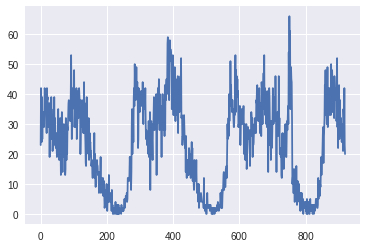

In [131]:
col_data = 'slategray'
col_getml = 'darkviolet'
col_getml_alt = 'coral'
col_prophet = 'cornflowerblue'

plt.plot(data_full_pandas["y"][:920])

### 1.2 Prepare data for getML

The `getml.datasets.load_interstate94` method took care of the entire data lifting:
* Downloads csv's from our servers into python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() & [units]() to columns inside getML DataFrames

In [132]:
data_full = getml.data.DataFrame.from_pandas(data_full_pandas, "data_full")
data_train = getml.data.DataFrame.from_pandas(data_train_pandas, "data_train")
data_test = getml.data.DataFrame.from_pandas(data_test_pandas, "data_test")

In [133]:
for df in [data_full, data_train, data_test]:
    df.set_role("y", getml.data.roles.target)
    df.set_role("ds", getml.data.roles.time_stamp)

In [134]:
data_full

Name,ds,y
Role,time_stamp,target
Unit,"time stamp, comparison only",
0,2005-04-11T07:35:00.000000Z,23
1,2005-04-11T07:40:00.000000Z,42
2,2005-04-11T07:45:00.000000Z,37
3,2005-04-11T07:50:00.000000Z,24
4,2005-04-11T07:55:00.000000Z,39
,...,...
47492,2005-09-30T23:45:00.000000Z,14
47493,2005-09-30T23:50:00.000000Z,12


__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables.

### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). This is done abstractly using [Placeholders](https://docs.getml.com/latest/user_guide/data_model/data_model.html#placeholders)

The data model consists of two tables:
* __Population table__ `traffic_{test/train}`: holds target and the contemporarily available time-based components
* __Peripheral table__ `traffic`: same table as the population table
* Join between both placeholders specifies (`horizon`) to prevent leaks and (`memory`) that keeps the computations feasible

In [135]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

# 1. The horizon is 1 hour (we predict the traffic volumn in hour). 
# 2. The memory is 6 hours, so we allow the algorithm to 
#    use information from up to 6 hours ago. 
# 3. We allow lagged targets. Thus, the algorithm can 
#    identify autoregressive processes.

population.join(
    peripheral,
    time_stamp='ds',
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.hours(2),
    allow_lagged_targets=True
)

population

placeholder,other placeholder,allow lagged targets,horizon,join keys used,memory,other join keys used,other time stamps used,relationship,time stamps used,upper time stamps used
population,peripheral,True,3600.0,,7200.0,,ds,many-to-many,ds,


## 2.Predictive modelling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [136]:
seasonal = getml.preprocessors.Seasonal()

multirel = getml.feature_learning.MultirelModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1
)

relboost = getml.feature_learning.RelboostModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1
)

predictor = getml.predictors.XGBoostRegressor()

__Build the pipeline__

In [137]:
pipe = getml.pipeline.Pipeline(
    tags=['memory: 2h', 'horizon: 1h', 'multirel', 'relboost'],
    population=population,
    peripheral=[peripheral],
    preprocessors=[seasonal],
    feature_learners=[multirel, relboost],
    predictors=[predictor]
)

### 2.2 Model training

In [138]:
pipe.check(data_train, [data_full])

Checking data model...
OK.


In [139]:
pipe.fit(data_train, [data_full])

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

RelboostModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:4m:5.012433



Pipeline(preprocessors=['Seasonal'], 
         feature_learners=['MultirelModel', 'RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['XGBoostRegressor'], 
         tags=['memory: 2h', 'horizon: 1h', 'multirel', 'relboost'], 
         share_selected_features=0.5)

url: http://localhost:1709/getpipeline/73ceaa/0/

### 2.3 Model evaluation

In [140]:
in_sample = pipe.score(
        population_table=data_train,
        peripheral_tables=[data_full]
)

out_of_sample = pipe.score(
        population_table=data_test,
        peripheral_tables=[data_full]
)

print("""
In sample mae: {:.2f}
In sample rmse: {:.2f}
In sample rsquared: {:.2f}\n
Out of sample mae: {:.2f}
Out of sample rmse: {:.2f}
Out of sample rsquared: {:.2f}
""".format(
    in_sample['mae'][0], 
    in_sample['rmse'][0],
    in_sample['rsquared'][0],
    out_of_sample['mae'][0], 
    out_of_sample['rmse'][0],
    out_of_sample['rsquared'][0])
)


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%


In sample mae: 4.64
In sample rmse: 6.43
In sample rsquared: 0.76

Out of sample mae: 4.71
Out of sample rmse: 6.52
Out of sample rsquared: 0.75



### 2.4 Studying features

__Feature correlations__

Correlations of the calculated features with the target

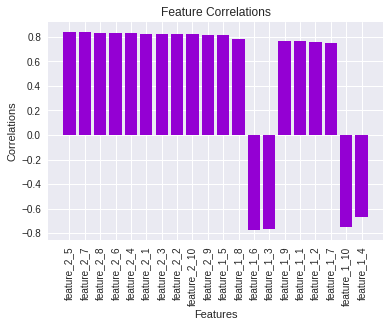

In [141]:
names, correlations = pipe.features.correlations()
plt.bar(names, correlations, color=col_getml)
plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

__Feature importances__

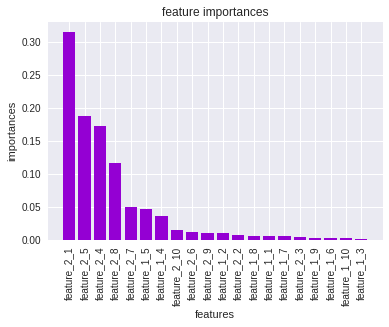

In [142]:
names, importances = pipe.features.importances()

plt.bar(names, importances, color=col_getml)
plt.title('feature importances')
plt.xlabel('features')
plt.ylabel('importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Visualizing the learned features__

SQL transpilation of most important Multirel feature. Here, Multirel aggregated past values of the target (from up to one week ago) conditional on time-related components to resemble the daily, weekly and monthly cycles in the series. We expect this approach to work reasonably well because the series exhibits strong and stable time-related patterns. 

In [143]:
pipe.features.to_sql()[most_important]

```sql
CREATE TABLE "FEATURE_2_1" AS
SELECT SUM( 
    CASE
        WHEN ( hour( t2."ds" ) IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( t2."y" > 18.841121 ) AND ( weekday( t2."ds" ) IN ( '0', '1', '2', '3', '4' ) ) THEN -1.133910
        WHEN ( hour( t2."ds" ) IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( t2."y" > 18.841121 ) AND ( weekday( t2."ds" ) NOT IN ( '0', '1', '2', '3', '4' ) ) THEN -0.717826
        WHEN ( hour( t2."ds" ) IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( t2."y" <= 18.841121 OR t2."y" IS NULL ) AND ( hour( t1."ds" ) IN ( '6' ) ) THEN -2.005518
        WHEN ( hour( t2."ds" ) IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( t2."y" <= 18.841121 OR t2."y" IS NULL ) AND ( hour( t1."ds" ) NOT IN ( '6' ) ) THEN -1.296032
        WHEN ( hour( t2."ds" ) NOT IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( hour( t2."ds" ) IN ( '8', '9', '10', '11', '17', '18', '19', '20', '4', '5' ) ) AND ( weekday( t2."ds" ) IN ( '0' ) ) THEN -0.731055
        WHEN ( hour( t2."ds" ) NOT IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( hour( t2."ds" ) IN ( '8', '9', '10', '11', '17', '18', '19', '20', '4', '5' ) ) AND ( weekday( t2."ds" ) NOT IN ( '0' ) ) THEN -0.371848
        WHEN ( hour( t2."ds" ) NOT IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( hour( t2."ds" ) NOT IN ( '8', '9', '10', '11', '17', '18', '19', '20', '4', '5' ) ) AND ( t2."y" > 9.802432 ) THEN -0.024587
        WHEN ( hour( t2."ds" ) NOT IN ( '21', '22', '23', '0', '1', '2', '3' ) ) AND ( hour( t2."ds" ) NOT IN ( '8', '9', '10', '11', '17', '18', '19', '20', '4', '5' ) ) AND ( t2."y" <= 9.802432 OR t2."y" IS NULL ) THEN -1.231180
        ELSE NULL
    END
) AS "feature_2_1",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON 1 = 1
WHERE datetime( t2."ds", '+1.000000 hours' ) <= datetime( t1."ds" )
AND ( datetime( t2."ds", '+3.000000 hours' ) > datetime( t1."ds" ) OR datetime( t2."ds", '+3.000000 hours' ) IS NULL )
GROUP BY t1.rowid;
```

In [144]:
predictions_getml_test = pipe.predict(data_test, [data_full])


MultirelModel: Building features...
[========================================] 100%

RelboostModel: Building features...
[========================================] 100%



In [145]:
model_prophet = Prophet()

model_prophet.fit(data_train_pandas)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [146]:
predictions_prophet_train = model_prophet.predict(data_train_pandas)["yhat"]

predictions_prophet_test = model_prophet.predict(data_test_pandas)["yhat"]

In [147]:
r = scipy.stats.pearsonr(predictions_prophet_train, data_train_pandas["y"])[0]
r_squared_prophet_train = r*r

r = scipy.stats.pearsonr(predictions_prophet_test, data_test_pandas["y"])[0]
r_squared_prophet_test = r*r

In [148]:
print(r_squared_prophet_train)
print(r_squared_prophet_test)

0.6654608847513073
0.6306120638729144


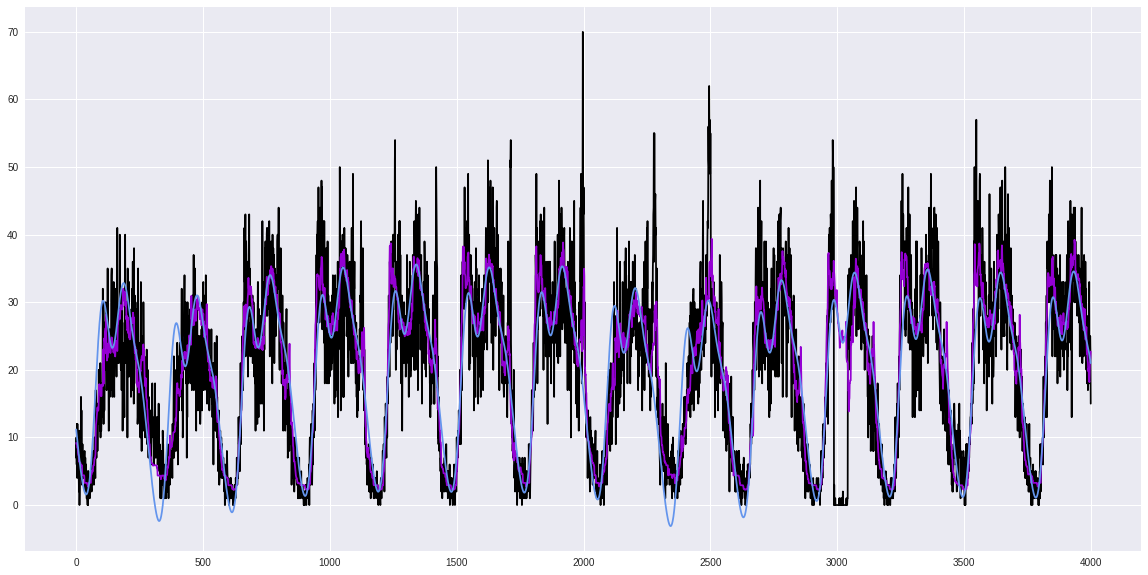

In [149]:
length = 4000

plt.subplots(figsize=(20, 10))

plt.plot(np.asarray(data_test_pandas["y"])[:length], color="black")
plt.plot(predictions_getml_test[:length], color=col_getml)
plt.plot(predictions_prophet_test[:length], color=col_prophet)

## 3. Conclusion

...

# Next Steps

This tutorial went through the basics of applying getML to time series. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Loan default prediction: Introduction to relational learning](loans_demo.ipynb)
* [Occupancy detection: A multivariate time series example](occupancy_demo.ipynb)  
* [Expenditure categorization: Why relational learning matters](consumer_expenditures_demo.ipynb)
* [Disease lethality prediction: Feature engineering and the curse of dimensionality](atherosclerosis_demo.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94_demo.ipynb)
* [Air pollution prediction: Why feature learning outperforms brute-force approaches](air_pollution_demo.ipynb) 


__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


While this tutorial focuses on the new aspects when working with getML, some more steps were required to prepare the raw data in its relational format. You will find the full analysis on Github in our [getml-examples](https://github.com/getml/getml-examples) repository.


# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.